In [1]:
import sqlite3
import pandas as pd
from snowflake.snowpark import Session
import joblib
import os
import gzip
import json
import io
from bs4 import BeautifulSoup
from TopicAnalysis import TopicAnalysis

In [2]:
conn_sqlite = sqlite3.connect('files/topic_analysis.db')
cursor_sqlite = conn_sqlite.cursor()

CONNECTION_PARAMETERS = {}

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [3]:
def initialize_tables():
    cursor_sqlite.execute("""CREATE TABLE IF NOT EXISTS templates (id TEXT PRIMARY KEY, html TEXT, text TEXT)""")
    cursor_sqlite.execute("""CREATE TABLE IF NOT EXISTS scores (id TEXT PRIMARY KEY, scores TEXT)""")
    conn_sqlite.commit()

In [4]:
def add_to_db():
    iterable_templates = os.path.join(os.getcwd(), 'files/templates/')
    for root, directories, files in os.walk(iterable_templates):
        if 'project' not in:
            continue
        for file in files:
            file_path = os.path.join(root, file)
            template_dicts = []
            with gzip.open(file_path, 'rb') as f:
                with io.TextIOWrapper(f, encoding='utf-8') as text_file:
                    for line in text_file:
                        template_data = json.loads(line)
                        campaign_id = template_data['campaign_id']
                        html = template_data['html']
                        soup = BeautifulSoup(html, 'html.parser')
                        text = soup.get_text().strip()
                        if not text:
                            continue
                        template_dicts.append({'id': campaign_id, 'html': html, 'text': text})
            df = pd.DataFrame(data=template_dicts)
            df.to_sql('templates', conn_sqlite, if_exists='append', index=False)
            print(f'Completed {root}')

In [6]:
cursor_sqlite.execute("""SELECT id, text FROM templates""")
results = cursor_sqlite.fetchall()
df = pd.DataFrame(data=results, columns=['id', 'text'])

In [12]:
topic_model = TopicAnalysis()
num_topcis = list(range(2, 21, 2))
perplexity_scores, coherence_scores = topic_model.get_num_topics_scoring(df['text'], num_topcis)

Starting topic 2
Starting topic 4
Starting topic 6
Starting topic 8
Starting topic 10
Starting topic 12
Starting topic 14
Starting topic 16
Starting topic 18
Starting topic 20


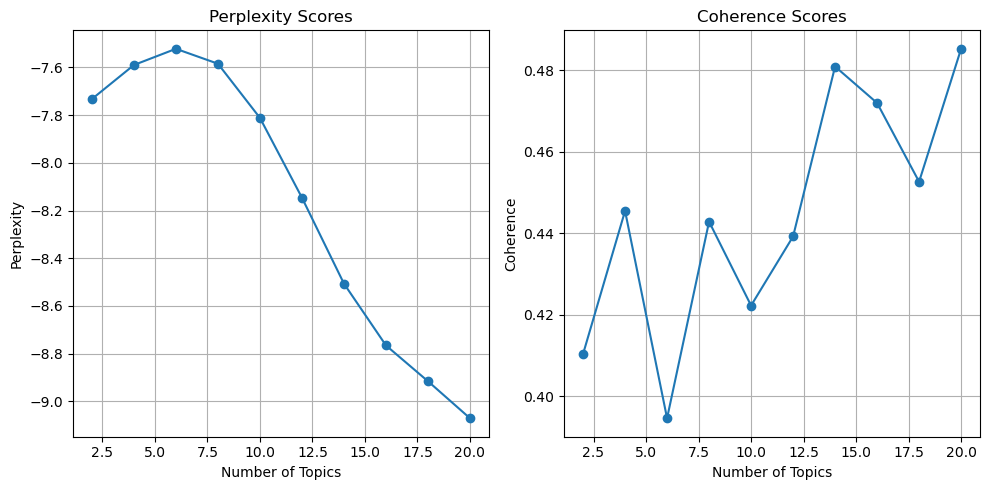

In [13]:
import matplotlib.pyplot as plt

def plot_scores(num_topics_range, perplexity_scores, coherence_scores):
    plt.figure(figsize=(10, 5))

    # Plot perplexity scores
    plt.subplot(1, 2, 1)
    plt.plot(num_topics_range, perplexity_scores, marker='o', linestyle='-')
    plt.title('Perplexity Scores')
    plt.xlabel('Number of Topics')
    plt.ylabel('Perplexity')
    plt.grid(True)

    # Plot coherence scores
    plt.subplot(1, 2, 2)
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-')
    plt.title('Coherence Scores')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_scores(num_topcis, perplexity_scores, coherence_scores)

In [15]:
topic_model = TopicAnalysis()
topic_model.train_model(df['text'], 12)
joblib.dump(topic_model, 'files/topic_model_gensim_12')

test = topic_model.lda_model.show_topics(num_topics=13)
test = sorted(test, key=lambda x: x[0])
topic_keywords = []
for topic in test:
    num = topic[0]
    phrases = topic[1]
    keywords = []
    for phrase in phrases.split('+'):
        keywords.append(phrase.split('"')[1].strip())
    topic_keywords.append((num, keywords))
for topic in topic_keywords:
    print(f'{topic[0]}: {topic[1]}')

0: ['colleg', 'hillsdal', 'american', 'cours', 'liberti', 'unsubscrib', 'hillsdal_colleg', 'educ', 'constitut', 'america']
1: ['unsubscrib', 'amend', 'second', 'right', 'click', 'gun', 'foundat', 'second_amend', 'click_unsubscrib', 'nra']
2: ['senat', 'help', 'donat', 'unsubscrib', 'contribut', 'conserv', 'democrat', 'support', 'need', 'republican']
3: ['texa', 'border', 'texan', 'cornyn', 'your', 'friend', 'go', 'abbott', 'wall', 'john']
4: ['constitut', 'nation', 'heritag', 'today', 'unsubscrib', 'foundat', 'conserv', 'guid', 'polici', 'youll']
5: ['trump', 'contribut', 'america', 'unsubscrib', 'presid', 'committe', 'support', 'pleas', 'great', 'make']
6: ['david', 'abort', 'prolif', 'life', 'parenthood', 'plan', 'legal', 'babi', 'pleas', 'plan_parenthood']
7: ['american', 'stand', 'fight', 'america', 'support', 'countri', 'freedom', 'biden', 'nation', 'elect']
8: ['conserv', 'student', 'book', 'help', 'unsubscrib', 'today', 'institut', 'america', 'american', 'campu']
9: ['contribut'

In [18]:
def get_scores(text):
    scores = topic_model.model_text(text)
    str_scores = [str(score) for score in scores]
    return ','.join(str_scores)
    
df['topic_scores'] = df['text'].apply(get_scores)

In [24]:
df.rename(columns={'topic_scores': 'scores'}, inplace=True)

In [27]:
df[['id', 'scores']].to_sql('scores', conn_sqlite, index=False)

28869